In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

### Problem 1

#### 1.1

In [19]:
tempX = np.random.uniform(-1,1,4000)
tempY = np.random.uniform(-1,1,4000)
myX = np.array([tempX, tempY]).T
def myfunc(X):
    return np.sin((X[:,0]**2 + X[:,1]**2)*2)
myy = myfunc(myX)

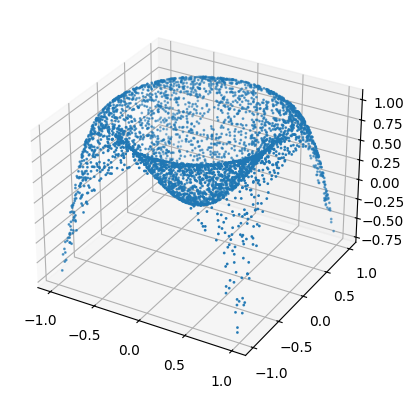

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(myX[:,0], myX[:,1], myy, s= 1)
plt.show()

In [25]:
myXcuda = torch.from_numpy(myX).to('cuda')
myycuda = torch.from_numpy(myy).to('cuda')
print(myXcuda.device)
print(myycuda.device)

cuda:0
cuda:0


In [31]:
train_ds = torch.utils.data.TensorDataset(myXcuda, myycuda)
batch_size = 10
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True)

In [32]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, hidden_size) 
        self.layer3 = nn.Linear(hidden_size, hidden_size) 
        self.layer4 = nn.Linear(hidden_size, output_size)  

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = nn.ReLU()(x)
        x = self.layer4(x)
        return x
        
input_size = 2
hidden_size = 32
output_size = 1
 
model = Model(input_size, hidden_size, output_size)
model = model.to('cuda')

learning_rate = 0.0001

loss_fn = nn.MSELoss()
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
num_epochs = 200
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = torch.squeeze(model(x_batch.float()))
        loss = loss_fn(pred, y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        # is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        # accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    # accuracy_hist[epoch] /= len(train_dl.dataset)

    if (epoch+1)%5==0:
        print('Epoch', epoch+1, ': MSE =', loss_hist[epoch])

Epoch 5 : MSE = 0.09432086353655905
Epoch 10 : MSE = 0.06457859848160297
Epoch 15 : MSE = 0.030557837929809466
Epoch 20 : MSE = 0.012619644904625603
Epoch 25 : MSE = 0.005202355201981845
Epoch 30 : MSE = 0.0019190582625378738
Epoch 35 : MSE = 0.0009017053583374946
Epoch 40 : MSE = 0.0005024277008578793
Epoch 45 : MSE = 0.00031527025638752095
Epoch 50 : MSE = 0.0002241882690032071
Epoch 55 : MSE = 0.00016477050257435622
Epoch 60 : MSE = 0.00014217341361927538
Epoch 65 : MSE = 0.0001243838122809393
Epoch 70 : MSE = 0.0001043667262638337
Epoch 75 : MSE = 0.00010089085313211399
Epoch 80 : MSE = 0.00010267303964383246
Epoch 85 : MSE = 8.564457771171874e-05
Epoch 90 : MSE = 8.209162612502041e-05
Epoch 95 : MSE = 7.669701881923174e-05
Epoch 100 : MSE = 7.702817422796216e-05
Epoch 105 : MSE = 7.63078321165267e-05
Epoch 110 : MSE = 7.217011421744247e-05
Epoch 115 : MSE = 6.426067084703391e-05
Epoch 120 : MSE = 6.779067321758702e-05
Epoch 125 : MSE = 6.618854810085395e-05
Epoch 130 : MSE = 5.939

#### 1.2

In [34]:
ttempX = np.random.uniform(-1,1,1000)
ttempY = np.random.uniform(-1,1,1000)

testX = np.array([ttempX, ttempY]).T
testy = myfunc(testX)

In [39]:
testXtensor = torch.from_numpy(testX)
testytensor = torch.from_numpy(testy)
model.to('cpu')
pred_test = torch.squeeze(model.forward(testXtensor.float()))
tloss = loss_fn(pred_test, testytensor.float()).item()
print('The MSE loss of the test data:', tloss)

The MSE loss of the test data: 4.616431033355184e-05


In [40]:
4.934705110372306e-05 - 4.616431033355184e-05

3.1827407701712213e-06

The MSE loss of the test dataset 3.1827407701712213e-06 lower than the final MSE of the train dataset in the previous part.

### Problem 2

In [14]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.distributions.categorical import Categorical

In [4]:
## Reading and processing text
## Romeo and Juliet
with open('pg1513.txt', 'r', encoding="utf8") as fp1:
    text1=fp1.read()

start_indx1 = text1.find('THE TRAGEDY OF ROMEO AND JULIET')
end_indx1 = text1.find('End of the Project Gutenberg')

text1 = text1[start_indx1:end_indx1]

## Midsummer Night's Dream
with open('pg1514.txt', 'r', encoding="utf8") as fp2:
    text2=fp2.read()
    
start_indx2 = text2.find('A MIDSUMMER NIGHT’S DREAM')
end_indx2 = text2.find('End of the Project Gutenberg')

text2 = text2[start_indx2:end_indx2]

## The Tempest
with open('pg23042.txt', 'r', encoding="utf8") as fp3:
    text3=fp3.read()
    
start_indx3 = text3.find('THE TEMPEST.')
end_indx3 = text3.find('End of the Project Gutenberg')

text3 = text3[start_indx3:end_indx3]

## Hamlet
with open('pg27761.txt', 'r', encoding="utf8") as fp4:
    text4=fp4.read()
    
start_indx4 = text4.find('HAMLET,')
end_indx4 = text4.find('End of the Project Gutenberg')

text4 = text4[start_indx4:end_indx4]

text = text1 + text2 + text3 + text4
char_set = set(text)

print('Text 1: ', len(text1))
print('Text 2: ', len(text2))
print('Text 3: ', len(text3))
print('Text 4: ', len(text4))
print('Combined Text: ', len(text))
print('Unique Characters:', len(char_set))

Text 1:  160982
Text 2:  115276
Text 3:  165371
Text 4:  220937
Combined Text:  662566
Unique Characters: 100


In [5]:
chars_sorted = sorted(char_set)
char2int = {ch:i for i,ch in enumerate(chars_sorted)}
char_array = np.array(chars_sorted)

text_encoded = np.array(
    [char2int[ch] for ch in text], dtype=np.int32)

In [6]:
seq_length = 50
chunk_size = seq_length + 1

text_chunks = [text_encoded[i:i+chunk_size] 
               for i in range(len(text_encoded)-chunk_size+1)] 

len(text_chunks)

662516

In [7]:
train_chunks, valid_chunks = train_test_split(text_chunks, test_size = 33125)
print(len(train_chunks))
print(len(valid_chunks))

629391
33125


In [8]:
class TextDataset(Dataset):
    def __init__(self, text_chunks):
        self.text_chunks = text_chunks

    def __len__(self):
        return len(self.text_chunks)
    
    def __getitem__(self, idx):
        text_chunk = self.text_chunks[idx]
        return text_chunk[:-1].long(), text_chunk[1:].long()
        
seq_dataset = TextDataset(torch.tensor(train_chunks))
valid_dataset = TextDataset(torch.tensor(valid_chunks))

/tmp/ipykernel_666/460726346.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  seq_dataset = TextDataset(torch.tensor(train_chunks))


In [9]:
device = 'cuda'
batch_size = 64

torch.manual_seed(1)
seq_dl = DataLoader(seq_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_dataset, batch_size=1, shuffle=True, drop_last=True)

In [10]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim) 
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, 
                           batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, vocab_size)

    def forward(self, x, hidden, cell):
        out = self.embedding(x).unsqueeze(1)
        out, (hidden, cell) = self.rnn(out, (hidden, cell))
        out = self.fc(out).reshape(out.size(0), -1)
        return out, hidden, cell

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.rnn_hidden_size)
        cell = torch.zeros(1, batch_size, self.rnn_hidden_size)
        return hidden.to(device), cell.to(device)
    
vocab_size = len(char_array)
embed_dim = 256
rnn_hidden_size = 512

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size) 
model = model.to(device)
model

RNN(
  (embedding): Embedding(100, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=100, bias=True)
)

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

num_epochs = 10000 

torch.manual_seed(1)

for epoch in range(num_epochs):
    # Train Dataset
    hidden, cell = model.init_hidden(batch_size)
    seq_batch, target_batch = next(iter(seq_dl))
    seq_batch = seq_batch.to(device)
    target_batch = target_batch.to(device)
    loss = 0

    # Valid Dataset
    valid_hidden, valid_cell = model.init_hidden(1)
    valid_seq_batch, valid_target_batch = next(iter(valid_dl))
    valid_seq_batch = valid_seq_batch.to(device)
    valid_target_batch = valid_target_batch.to(device)
    valid_loss = 0

    optimizer.zero_grad()
    
    for c in range(seq_length):
        pred, hidden, cell = model(seq_batch[:, c], hidden, cell) 
        loss += loss_fn(pred, target_batch[:, c])
    loss.backward()
    optimizer.step()

    for c in range(seq_length):
        valid_pred, valid_hidden, valid_cell = model(valid_seq_batch[:, c], valid_hidden, valid_cell) 
        valid_loss += loss_fn(valid_pred, valid_target_batch[:, c])

    loss = loss.item()/seq_length
    valid_loss = valid_loss.item()/seq_length
    
    if (epoch+1) % 500 == 0:
        print(f'Epoch {epoch+1}: train loss = {loss:.4f} | valid loss = {valid_loss:.4f}')

Epoch 500: train loss = 1.4625 | valid loss = 1.5243
Epoch 1000: train loss = 1.4237 | valid loss = 1.5971
Epoch 1500: train loss = 1.2496 | valid loss = 0.8162
Epoch 2000: train loss = 1.3133 | valid loss = 0.9002
Epoch 2500: train loss = 1.2892 | valid loss = 1.4749
Epoch 3000: train loss = 1.2193 | valid loss = 1.0919
Epoch 3500: train loss = 1.1627 | valid loss = 1.2489
Epoch 4000: train loss = 1.1406 | valid loss = 1.1997
Epoch 4500: train loss = 1.1294 | valid loss = 0.5044
Epoch 5000: train loss = 1.1629 | valid loss = 0.6815
Epoch 5500: train loss = 1.2283 | valid loss = 1.0139
Epoch 6000: train loss = 1.1337 | valid loss = 1.1956
Epoch 6500: train loss = 1.2582 | valid loss = 1.2802
Epoch 7000: train loss = 1.1353 | valid loss = 0.7394
Epoch 7500: train loss = 1.2084 | valid loss = 0.9534
Epoch 8000: train loss = 1.1622 | valid loss = 1.3887
Epoch 8500: train loss = 1.1788 | valid loss = 0.4881
Epoch 9000: train loss = 1.2346 | valid loss = 1.0092
Epoch 9500: train loss = 1.31

In [17]:
def sample(model, starting_str, 
           len_generated_text=600, 
           scale_factor=1.0):

    encoded_input = torch.tensor([char2int[s] for s in starting_str])
    encoded_input = torch.reshape(encoded_input, (1, -1))

    generated_str = starting_str

    model.eval()
    hidden, cell = model.init_hidden(1)
    hidden = hidden.to('cpu')
    cell = cell.to('cpu')
    for c in range(len(starting_str)-1):
        _, hidden, cell = model(encoded_input[:, c].view(1), hidden, cell) 
    
    last_char = encoded_input[:, -1]
    for i in range(len_generated_text):
        logits, hidden, cell = model(last_char.view(1), hidden, cell) 
        logits = torch.squeeze(logits, 0)
        scaled_logits = logits * scale_factor
        m = Categorical(logits=scaled_logits)
        last_char = m.sample()
        generated_str += str(char_array[last_char])
        
    return generated_str

torch.manual_seed(1)
model.to('cpu')

RNN(
  (embedding): Embedding(100, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=100, bias=True)
)

#### Example 1:

In [18]:
print(sample(model, starting_str='Shakespearean'))

Shakespeareand
    measure of tam ris nymble, nonpauls!
Here steeled him, Laybran? And where stickness.

Crre, if he does elevited. An thy charmente’s eyes.
Let him hear, that suck not find mine release
that we have so unctive for the phrase? Princent Paris, Opheliet, you ghost!
That has a poor when the canst conjurd, there wwords._]

MONATION.
Ancisit!
Comes, till your personages, says it didst thyself, and put. Mr.
Not Lysander, doth had my cautions hences for father
The signified to what where to you, my minds it_ Reademan by Heaver
To you make this sairies’d into tilled me, what, stick tend.
To Juliet’


#### Example 2:

In [22]:
print(sample(model, starting_str='Shakespearean'))

Shakespeareandation and the
assistiance with fearful with the
samely sid or parting them bout me in. But thy noble rhymia,
And if thou make you with your generations.
I see this coil, are right you I have been thousand,
  Speak to a commation paid,
Of my dukedom in promise oursely,
That is to your have I husband, for a
written copying not.
Now, if they rought I had lace from the ribibia jincies is the
pontent checulians. If you will asret.

ROMEO.
What shoething with woeful,
Or, no matter? I then, I know night,
Hath slay, in these art here's hunners, every
none is to be like me.

FIRST YOU THIUS HAth Hermi
